# Notebook of Model Training for Potato Image Classification

The data can be found at: https://www.kaggle.com/datasets/arjuntejaswi/plant-village

In this notebook, we will process the data, split it into training and test sets and then build a CNN model for performing the classification predictions.

In [25]:
import tensorflow as tf
from tensorflow.keras import models,layers

import matplotlib.pyplot as plt

In [26]:
# define the image size and the batch size
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [27]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [28]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [29]:
len(dataset) 
# it shows length 68 because we have divided our data into batches of 32. therefore we get 68 such batches

68

2024-01-09 14:05:45.136890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-01-09 14:05:45.137379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


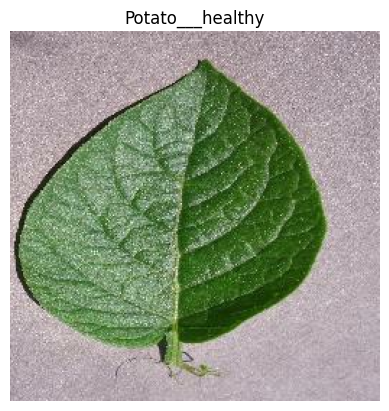

In [30]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[0]])
    plt.show()

2024-01-09 14:42:47.864724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-01-09 14:42:47.865008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]


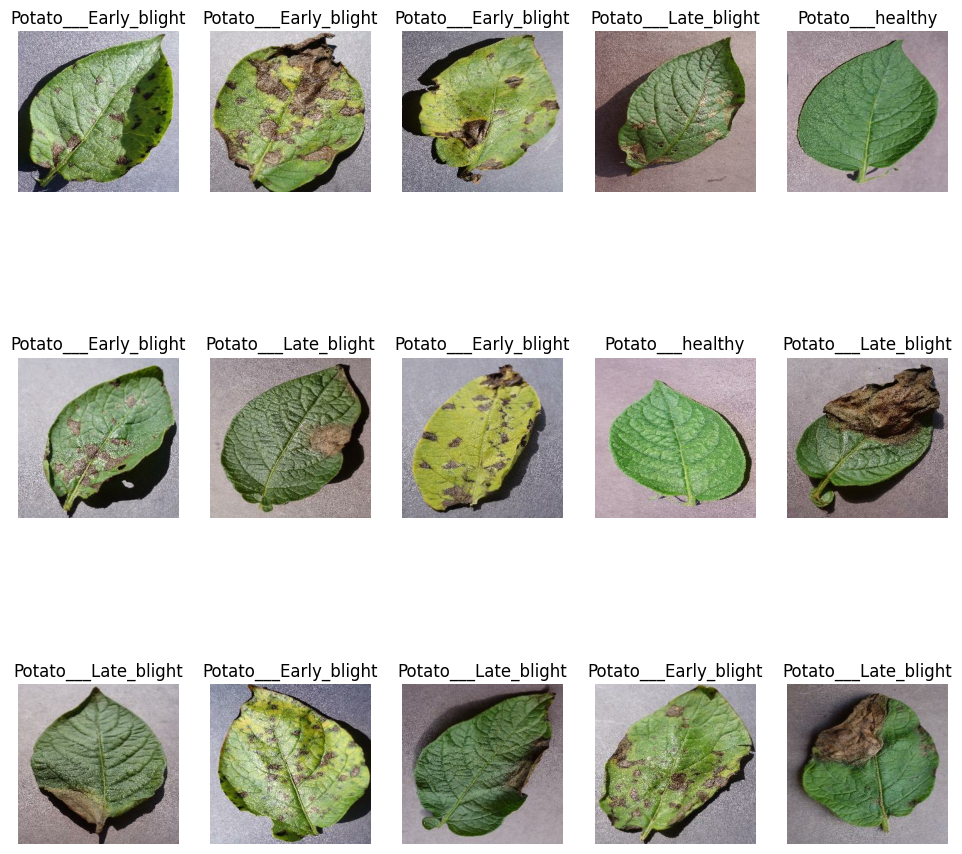

In [56]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

For Train Test Split, we will do a split of 80-20 where 80 percent will be our training set, and 20 percent will be testing and validation set.

We keep 10 percent for validation set and last 10 percent for testing. The validation set will be used while model training to find the model's performance, whereas the test set, we will use once our model is built.

In [32]:
# In sklearn we have train-test split. But we don't have that here. Hence we'll use dataset.take()
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [33]:
# TRAIN DATASET
train_dataset = dataset.take(54)
len(train_dataset)

54

In [34]:
remaining = dataset.skip(54)
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [35]:
# VALIDATION DATASET
val_dataset = remaining.take(6)
len(val_dataset)

6

In [36]:
# TEST DATASET
test_ds = remaining.skip(6)
len(test_ds)

8

In [37]:
# Lets create a nice python function to do the train test split that we did above
def create_train_test_split(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(dataset)

    if shuffle:
        ds = dataset.shuffle(shuffle_size,seed=42)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = dataset.take(train_size)

    val_ds = dataset.skip(train_size).take(val_size)

    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [38]:
train_ds,val_ds,test_ds = create_train_test_split(dataset)

In [39]:
len(test_ds)

8

In [40]:
len(train_ds)

54

In [41]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# This will help in better performance as the images will be stored in cache and we don't have to load them again and again

In [42]:
# Preprocessing our images and apply augmentation
resize_rescale = tf.keras.Sequential(
    [   
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1.0/255) 
    ]
)
# our images are already 256x256, so why are we resizing in the pipeline. This is because during prediction if our 
# image is not 256x256 it will cause problems. Hence we are resizing them beforehand so that all the images are of same size

# generally our images are in range of 0 to 255. using resclaing, we scale their values between 0 and 1

In [43]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomContrast(factor=(0.5, 1.5))


    ]
)

# Model Training

In [44]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model = models.Sequential(
    [
        resize_rescale,
        data_augmentation,
        layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(64,activation='relu'),
        layers.Dense(n_classes,activation='softmax')

    ]  
)
model.build(input_shape=input_shape)

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [46]:
# compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
# training the model(fitting it to our data)

with tf.device('/gpu:0'): # only run with this if you have gpu device available. else just remove the with statement and the later indentation.
    history = model.fit(
        train_ds,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        verbose=1,
        validation_data = val_ds
    )

Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.5191

2024-01-09 14:08:55.657537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]
2024-01-09 14:08:55.658201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - 148s 3s/step - loss: 0.8767 - accuracy: 0.5191 - val_loss: 0.7508 - val_accuracy: 0.7552
Epoch 2/10
54/54 [==============================] - 151s 3s/step - loss: 0.5316 - accuracy: 0.7818 - val_loss: 0.4205 - val_accuracy: 0.8073
Epoch 3/10
54/54 [==============================] - 154s 3s/step - loss: 0.4202 - accuracy: 0.8362 - val_loss: 0.7064 - val_accuracy: 0.6927
Epoch 4/10
54/54 [==============================] - 146s 3s/step - loss: 0.3585 - accuracy: 0.8715 - val_loss: 0.2688 - val_accuracy: 0.8854
Epoch 5/10
54/54 [==============================] - 140s 3s/step - loss: 0.2463 - accuracy: 0.9091 - val_loss: 0.1916 - val_accuracy: 0.9167
Epoch 6/10
54/54 [==============================] - 135s 3s/step - loss: 0.3075 - accuracy: 0.8808 - val_loss: 0.2143 - val_accuracy: 0.9271
Epoch 7/10
54/54 [==============================] - 128s 2s/step - loss: 0.2599 - accuracy: 0.9051 - val_loss: 0.2219 - val_accuracy: 0.8958
Epoch 8/10
54/54 [======

In [49]:
scores = model.evaluate(test_ds)

2024-01-09 14:30:18.200418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-01-09 14:30:18.202191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


6/6 [==============================] - 3s 483ms/step - loss: 0.4325 - accuracy: 0.8021


## Plotting Model History

In [50]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
history.history['accuracy']

[0.5190972089767456,
 0.7818287014961243,
 0.8362268805503845,
 0.8715277910232544,
 0.9091435074806213,
 0.8807870149612427,
 0.9050925970077515,
 0.9311342835426331,
 0.9270833134651184,
 0.9328703880310059]

In [53]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


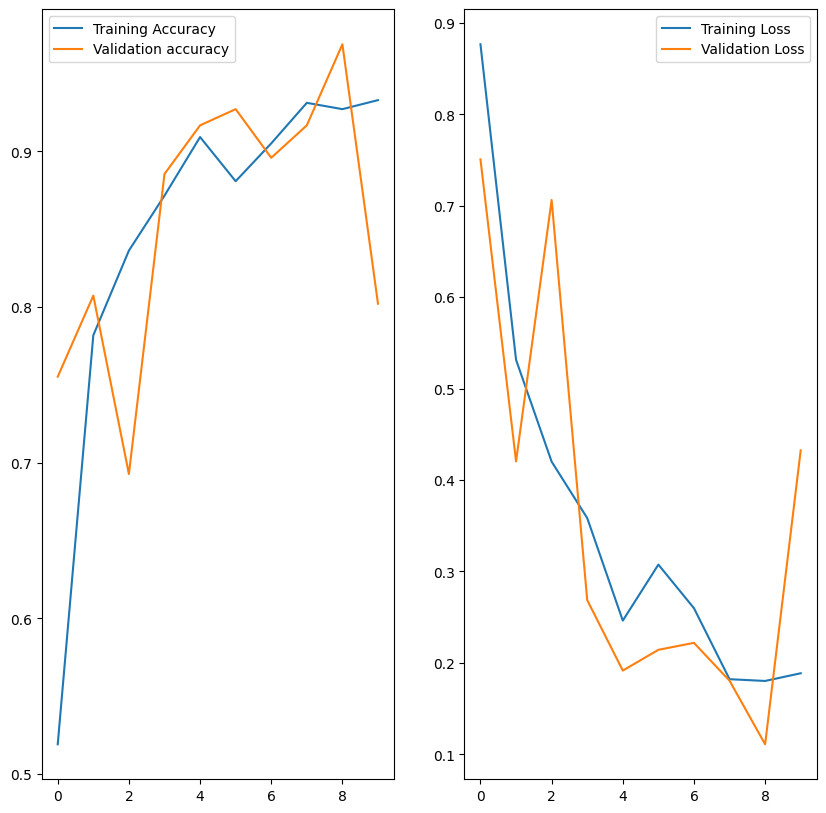

In [55]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend()